<a href="https://colab.research.google.com/github/JaniVarga/Skin_detection/blob/main/SAM2_label_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation with SAM2
link: https://github.com/facebookresearch/sam2

link: https://github.com/facebookresearch/sam2/blob/main/notebooks/image_predictor_example.ipynb

MPS: https://medium.com/@khalid.preneurlab07/mps-vs-gpu-cuda-for-deep-learning-which-one-should-you-use-6be9644d2038




In [1]:
# Clone the sam2 git reposity to "/content/segment_anything_2"
!git clone https://github.com/facebookresearch/sam2.git /content/segment_anything_2

Cloning into '/content/segment_anything_2'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 974 (delta 17), reused 18 (delta 6), pack-reused 936 (from 1)
Receiving objects: 100% (974/974), 128.94 MiB | 18.31 MiB/s, done.
Resolving deltas: 100% (334/334), done.


In [2]:
# Move the directory where the setup.py is located
%cd segment_anything_2

/content/segment_anything_2


In [3]:
# the "-e" flag tells pip to install in editable mode,  "." will execute the setup.py (or pyproject.toml) file in the current directory
!pip install -e .

Obtaining file:///content/segment_anything_2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.0 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-cp310-cp310-linux_x86_64.whl size=13398 sha256=513744e4e4fd5aefb332e5589eef490cc633b67e5cdc060f3edfaac9c5b98a87
  Stored in directory: /tmp/pip-ephem-wheel-cache-5eezi3ld/wheels/28/5b/24/556cbf83e4213f8514ce0aa6ab0e4fc9a0d0828a9dc3

In [1]:
# Install hydra necessary for SAM2
!pip install -q hydra-core

In [2]:
# Check that GPU accelerator is available
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}")

if device == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

cuda


In [3]:
# Setup test image path
img_path = "/content/1728293261557.jpeg"

Image mode:RGB, Image size:(1080, 1920)
Image type:uint8, Image shape:(1920, 1080, 3)


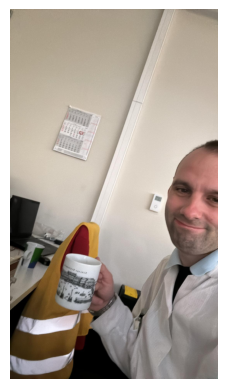

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

with Image.open(img_path) as image:
  image.load()

# Check image mode and size
print(f"Image mode:{image.mode}, Image size:{image.size}")

# Coner PIL.iamge into np.array
image = np.array(image)
print(f"Image type:{image.dtype}, Image shape:{image.shape}")

# Show the test Image
plt.imshow(image)
plt.axis("off")
plt.show()

In [5]:
# Download checkpoint
# We can download all the checkpoints: !/content/segment_anything_2/checkpoints/download_ckpts.sh
# Or we can download only which we want to use (You can copy the the url from the download_ckpts.sh file)
!wget "http://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt"

--2024-11-18 13:36:40--  http://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (176M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_small.pt’

sam2.1_hiera_small. 100%[===================>] 175.87M   214MB/s    in 0.8s    

2024-11-18 13:36:41 (214 MB/s) - ‘sam2.1_hiera_small.pt’ saved [184416285/184416285]



In [6]:
# Setup model checkpoint path and model cfg path
sam2_checkpoint_path = "/content/sam2.1_hiera_small.pt"
model_cfg_path = "configs/sam2.1/sam2.1_hiera_s.yaml" # AAA https://github.com/facebookresearch/sam2/issues/81

In [7]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# load the SAM 2 model
sam2_model = build_sam2(model_cfg_path, sam2_checkpoint_path, device=device)

# load predictor
predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)

/content/segment_anything_2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [8]:
# Select Flori's face choose a point on it. format and come with labels 1 (foreground point) or 0 (background point).
input_point = np.array([[1000, 790]]) # Points are input to the model in (x,y)
input_label = np.array([1]) # format and come with labels 1 (foreground point) or 0 (background point).

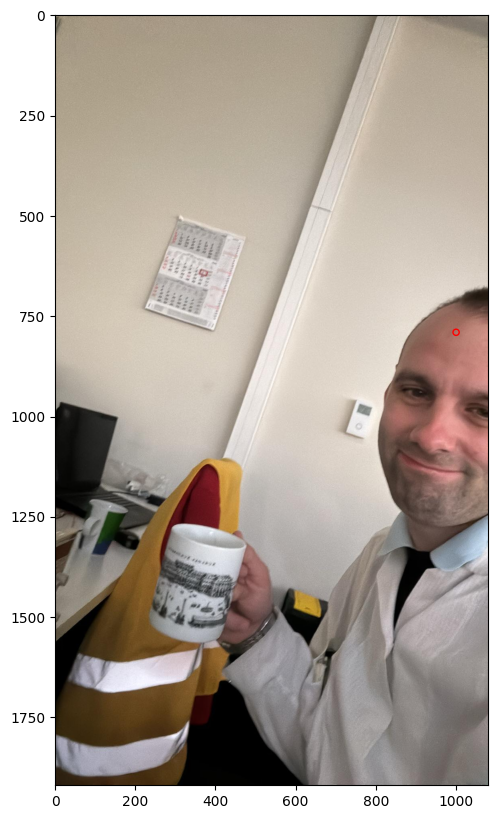

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.scatter(input_point[:, 0], input_point[:, 1], s=20, facecolors="none", edgecolors="red")
plt.show()

In [10]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True, # SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks.
)

In [11]:
# 3 masks
masks.shape

(3, 1920, 1080)

In [12]:
# Score the model's own estimation of the quality of these masks
scores

array([0.37695312, 0.46679688, 0.921875  ], dtype=float32)

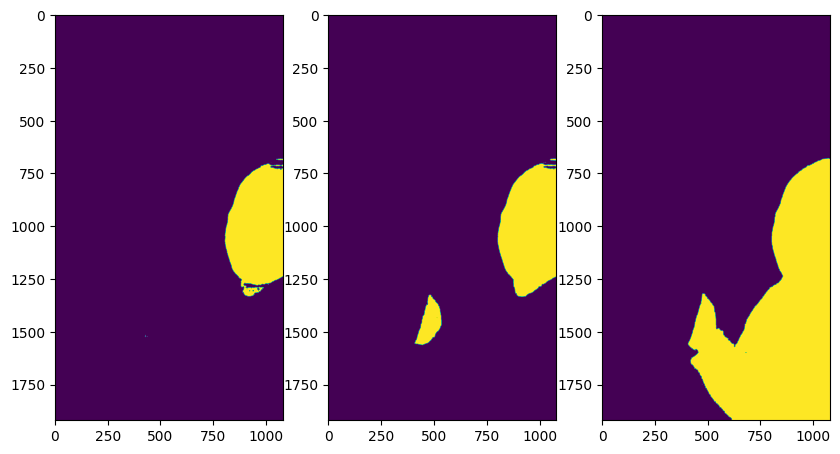

In [13]:
# Show the masks
fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
ax[0].imshow(masks[0])
ax[1].imshow(masks[1])
ax[2].imshow(masks[2])
plt.show()

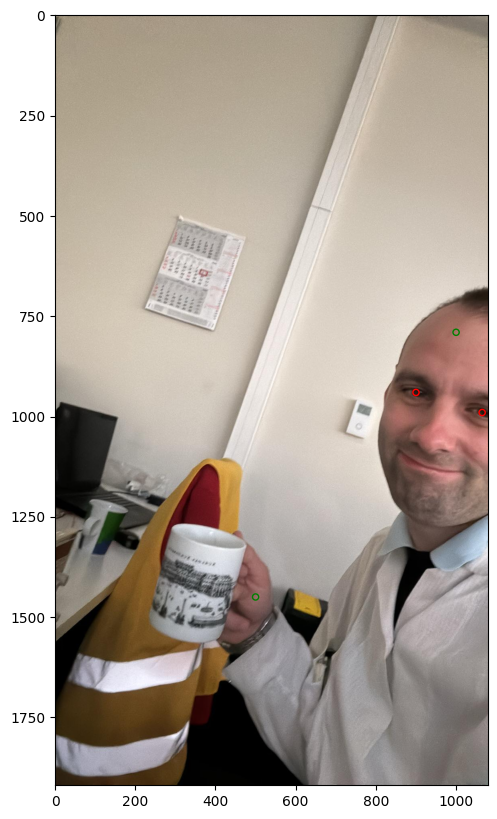

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.scatter(1000, 790, s=20, facecolors="none", edgecolors="green")
ax.scatter(900, 940, s=20, facecolors="none", edgecolors="red")
ax.scatter(1065, 990, s=20, facecolors="none", edgecolors="red")
ax.scatter(500, 1450, s=20, facecolors="none", edgecolors="green")
plt.show()

In [15]:
# Selected more points
input_point = np.array([[1000, 790], [900, 940], [1065,990], [500, 1450]]) # Points are input to the model in (x,y)
input_label = np.array([1,0,0,1]) # format and come with labels 1 (foreground point) or 0 (background point).

In [16]:
masks_2_points, scores_2_points, logits_2_points = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True, # SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks.
)

In [17]:
scores_2_points

array([0.75      , 0.58203125, 0.46679688], dtype=float32)

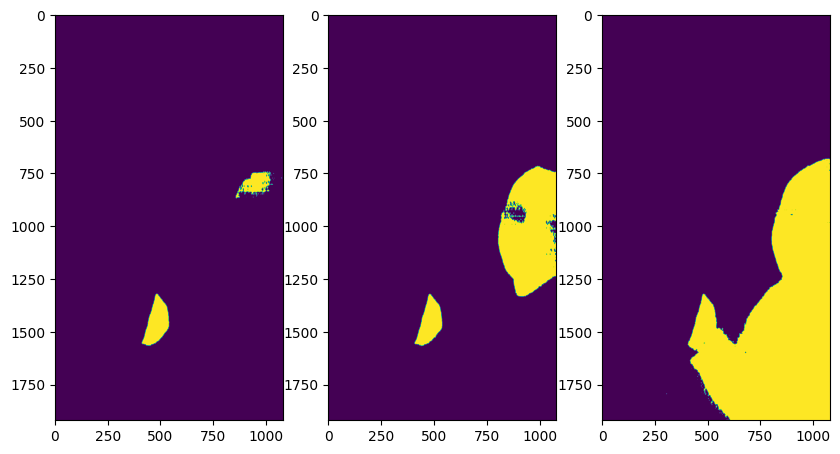

In [18]:
# Show the masks
fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
ax[0].imshow(masks_2_points[0])
ax[1].imshow(masks_2_points[1])
ax[2].imshow(masks_2_points[2])
plt.show()

In [19]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [20]:
# Specifying objects with a box (xyxy format)
input_box = np.array([800, 720, 1080, 1290]) # face
# input_box = np.array([400,1600,550,1285]) # hand

In [21]:
# Change xyxy format to x0, y0, w, h format
x0, y0 = input_box[0], input_box[1]
w, h = input_box[2] - input_box[0], input_box[3] - input_box[1]

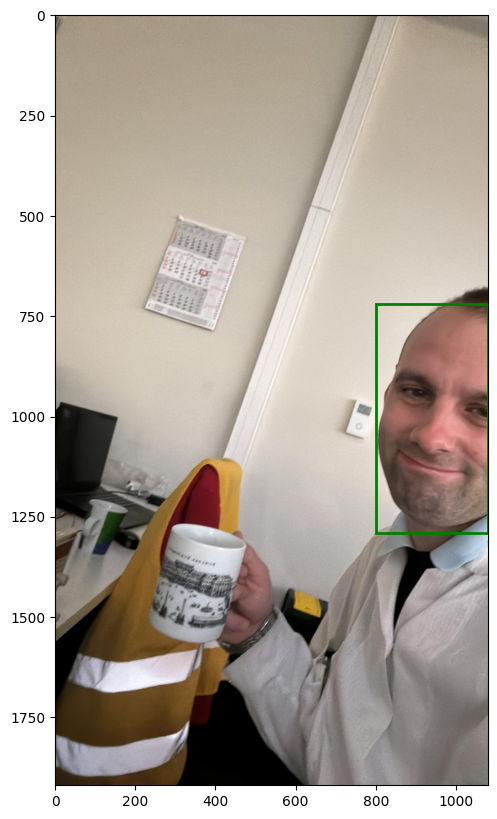

In [22]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.add_patch(Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))
plt.show()

In [23]:
masks_rectangle, scores_rectangle, logits_rectangle = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=True, # SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks.
)

In [24]:
scores_rectangle

array([0.9296875 , 0.97265625, 0.94921875], dtype=float32)

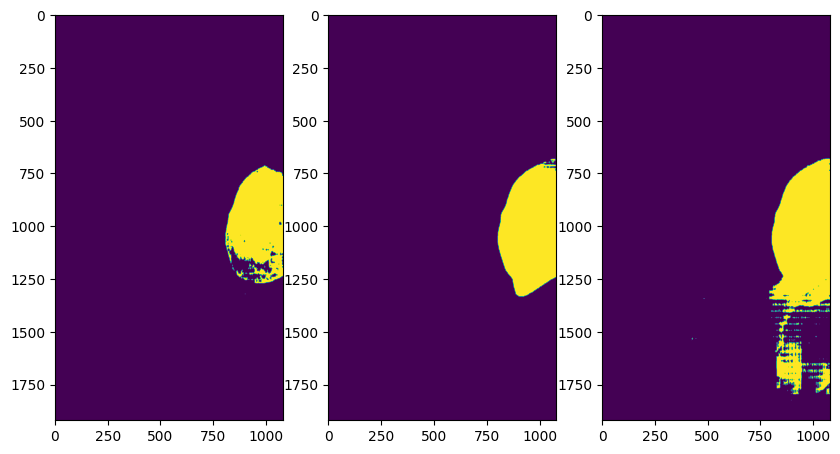

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
ax[0].imshow(masks_rectangle[0])
ax[1].imshow(masks_rectangle[1])
ax[2].imshow(masks_rectangle[2])
plt.show()

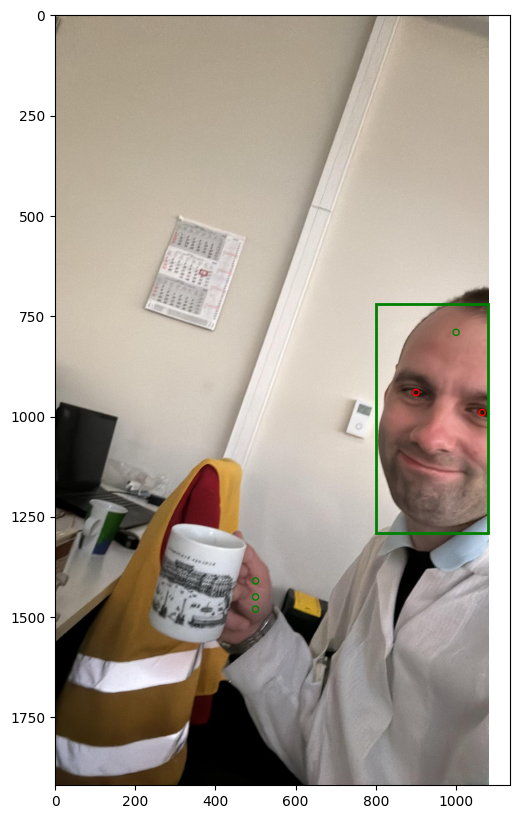

In [26]:
# Combining points and boxes
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.scatter(1000, 790, s=20, facecolors="none", edgecolors="green")
ax.scatter(900, 940, s=20, facecolors="none", edgecolors="red")
ax.scatter(1065, 990, s=20, facecolors="none", edgecolors="red")
ax.scatter(500, 1450, s=20, facecolors="none", edgecolors="green")
ax.scatter(500, 1410, s=20, facecolors="none", edgecolors="green")
ax.scatter(500, 1480, s=20, facecolors="none", edgecolors="green")
ax.add_patch(Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))
plt.show()

In [27]:
input_box = np.array([800, 720, 1080, 1290])
input_point = np.array([#[1000, 790],
                        [900, 940],
                        [1065,990],
                        [500, 1450],
                        [500,1410],
                         [500,1480]])
input_label = np.array([#1,
                        0,
                        0,
                        1,
                        1,
                        1])

In [28]:
masks_combinate_1, scores_combinate_1, logits_combinate_1 = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=True, # SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks.
)

In [29]:
scores_combinate_1

array([0.08496094, 0.14550781, 0.12597656], dtype=float32)

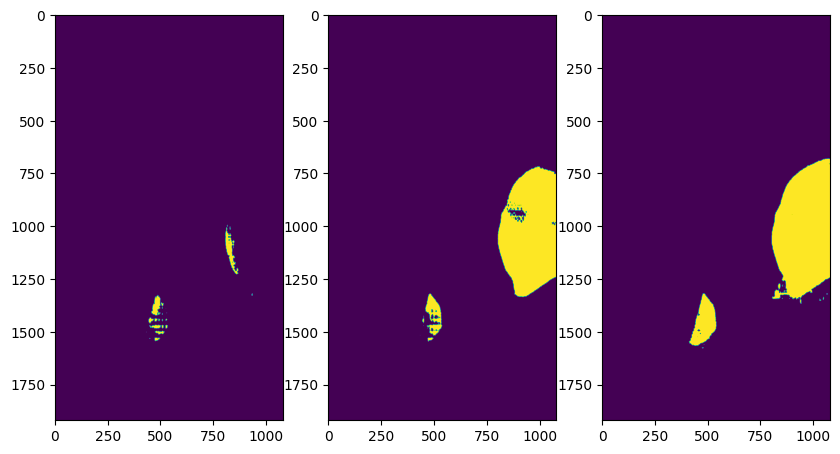

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
ax[0].imshow(masks_combinate_1[0])
ax[1].imshow(masks_combinate_1[1])
ax[2].imshow(masks_combinate_1[2])
plt.show()

In [31]:
# Batched prompt inputs
input_box = np.array([[800, 720, 1080, 1290],
                     [400,1600,550,1285]])

In [32]:
masks_combinate_rectangle, scores_combinate_rectangle, logits_rectangle = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=True, # SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks.
)

In [33]:
scores_combinate_rectangle

array([[0.9296875 , 0.97265625, 0.94921875],
       [0.00405884, 0.01000977, 0.01245117]], dtype=float32)

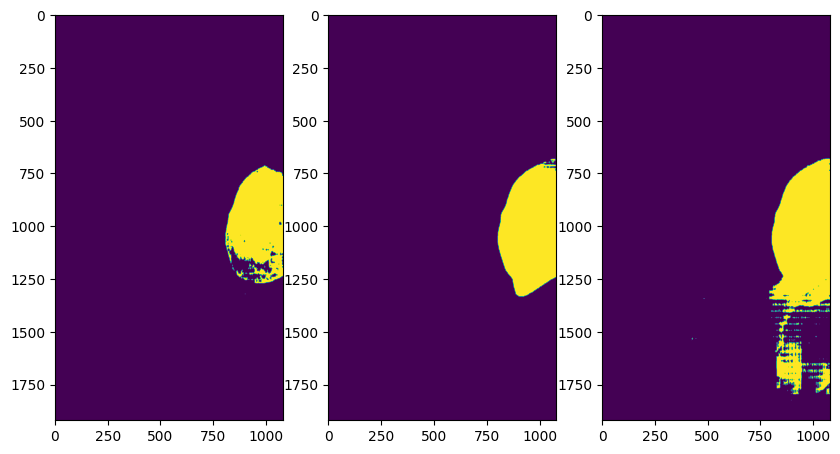

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
ax[0].imshow(masks_combinate_rectangle[0][0])
ax[1].imshow(masks_combinate_rectangle[0][1])
ax[2].imshow(masks_combinate_rectangle[0][2])
plt.show()

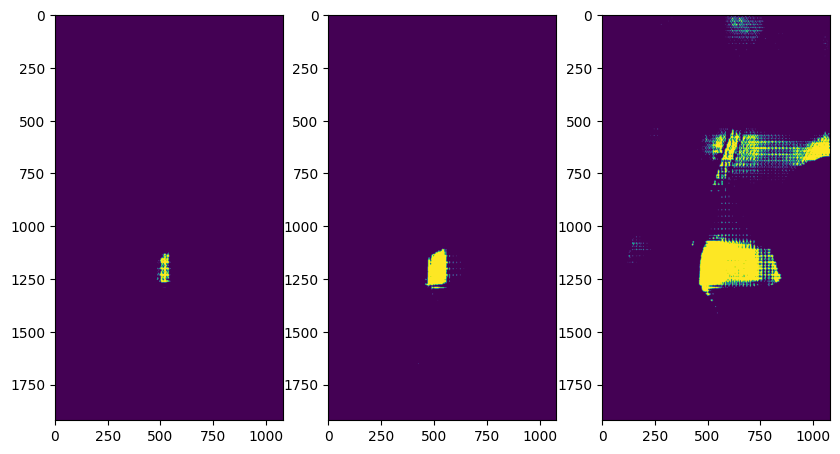

In [35]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
ax[0].imshow(masks_combinate_rectangle[1][0])
ax[1].imshow(masks_combinate_rectangle[1][1])
ax[2].imshow(masks_combinate_rectangle[1][2])
plt.show()

# Image segmentation with SAM2 automatic

link for automatic: https://github.com/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb



In [36]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint_path = "/content/sam2.1_hiera_small.pt"
model_cfg_path = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2 = build_sam2(model_cfg_path, sam2_checkpoint_path, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [37]:
masks = mask_generator.generate(image)

In [38]:
print(f"Area numbers: {len(masks)}")
print(masks[0].keys())

Area numbers: 14
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [39]:
print(f"The mask: \n{masks[0]['segmentation']}\n\n"
        f"The area of the mask in pixels: {masks[0]['area']}\n\n"
        f"The boundary box of the mask in XYWH format: {masks[0]['bbox']}\n\n"
        f"The model's own prediction for the quality of the mask: {masks[0]['predicted_iou']}\n\n"
        f"The sampled input point that generated this mask: {masks[0]['point_coords']}\n\n"
        f"An additional measure of mask quality: {masks[0]['stability_score']}\n\n"
        f"The crop of the image used to generate this mask in XYWH format: {masks[0]['crop_box']}")

The mask: 
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]

The area of the mask in pixels: 609054

The boundary box of the mask in XYWH format: [0.0, 0.0, 796.0, 1174.0]

The model's own prediction for the quality of the mask: 0.98828125

The sampled input point that generated this mask: [[489.375, 630.0]]

An additional measure of mask quality: 0.9807896614074707

The crop of the image used to generate this mask in XYWH format: [0.0, 0.0, 1080.0, 1920.0]


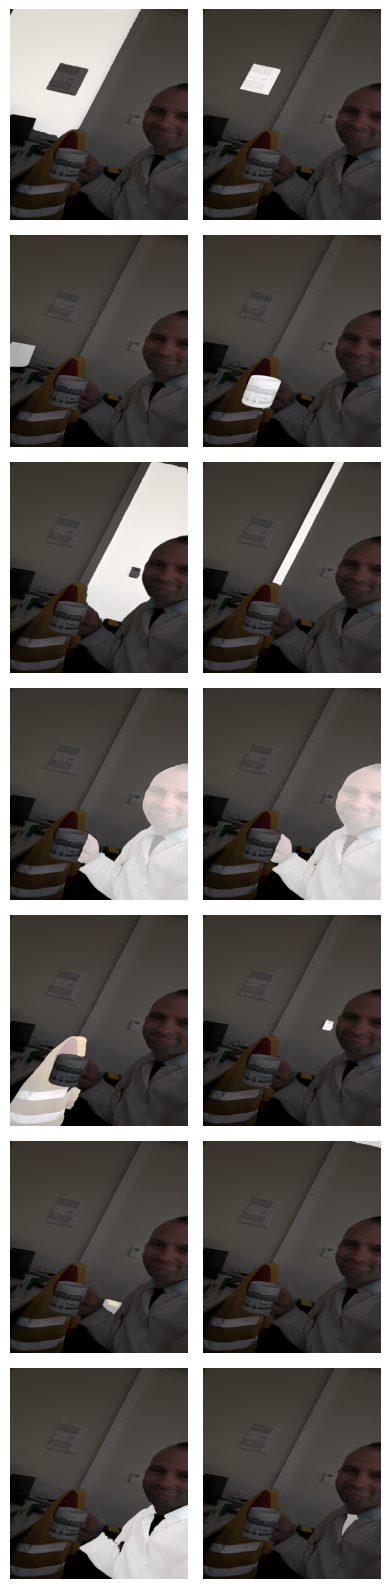

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=int(np.round((len(masks))/2)), figsize=(4, 16))
for i,ax in enumerate(ax.flatten()):
  ax.imshow(masks[i]["segmentation"], 'gray')
  ax.imshow(image, alpha=0.35,  aspect='auto')
  ax.axis('off')
plt.tight_layout()
plt.show()


## Automatic mask generation options

In [41]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2, # The SAM 2 model to use for mask prediction.
    points_per_side=32, # The number of points to be sampled along one side of the image. The total number of points is points_per_side**2. If None, 'point_grids' must provide explicit point sampling
    points_per_batch=32, #  Sets the number of points run simultaneously by the model
    pred_iou_thresh=0.7, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.95,
    stability_score_offset=0.5,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=3500.0,
    use_m2m=True,
)

In [42]:
masks2 = mask_generator_2.generate(image)

In [43]:
print(len(masks2))

10


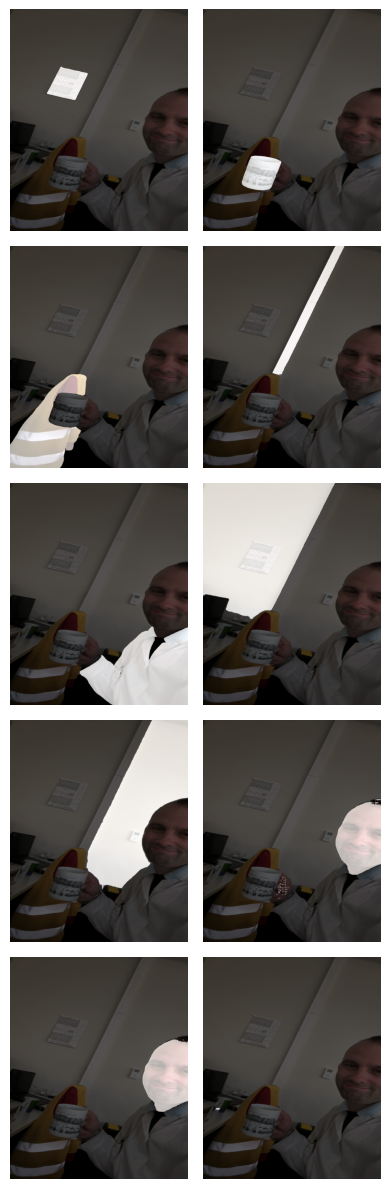

In [44]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(4, 12))
for i,ax in enumerate(axes.flatten()):
  ax.imshow(masks2[i]["segmentation"], 'gray')
  ax.imshow(image, alpha=0.35,  aspect='auto')
  ax.axis('off')
plt.tight_layout()
plt.show()